In [ ]:
%%capture
!pip install datasets
!pip install transformers -U
!pip install accelerate -U

In [ ]:
from datasets import load_dataset
dataset = load_dataset('coai/plantuml_generation')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1940 [00:00<?, ? examples/s]

In [ ]:
print(dataset['train'][:2])

{'text': ['<s>[INST]\nFor the given description, generate \na Sequence diagram diagram using plantuml. \nDescription: Use Case Name: Patient Registration\nUse Case ID: HC-001\n\nUse Case Description:\nThis use case describes the process of registering a new patient in a healthcare system.\n\nUse Case Actors:\n1. Front desk staff\n2. Patient\n\nUse Case Triggers:\n- A new patient arrives at the healthcare facility and wants to register.\n\nUse Case Preconditions:\n- The patient has not been registered in the system before.\n- The front desk staff is available to assist the patient.\n\nUse Case Postconditions:\n- The patient\'s information is recorded in the healthcare system.\n- The patient is assigned a unique identification number.\n\nUse Case Flow:\n1. The patient approaches the front desk and expresses the intention to register.\n2. The front desk staff welcomes the patient and requests basic information such as name, date of birth, address, contact number, and insurance details.\n3

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,12.086200,11.018160
2,4.598900,3.789405
3,2.775300,2.180560
4,2.206300,1.843375
5,1.950000,1.629425
6,1.842100,1.492345
7,1.747600,1.387081
8,1.610300,1.308424
9,1.552300,1.242799
10,1.383100,1.192116


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


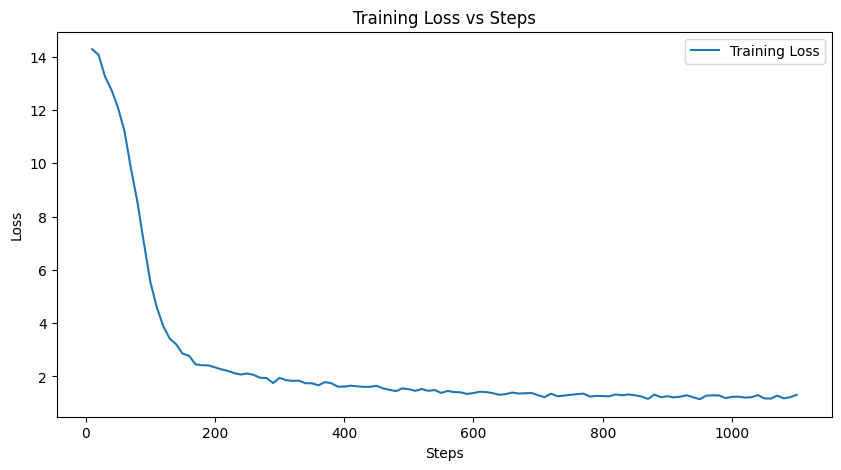

In [ ]:
import torch
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt

# Clear GPU cache
torch.cuda.empty_cache()

# Import the data
data_import = load_dataset("coai/plantuml_generation")

def prepare_input(input_data):
    segments = re.sub(r'|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': segments[1].strip()
    }

prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

data_frame = pd.DataFrame(prepared_data_array)

# Split the data as train and test data
train_df, val_df = train_test_split(data_frame, test_size=0.1, random_state=42)

# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Add special tokens to the tokenizer (if any)
special_tokens_dict = {'additional_special_tokens': ['</s>']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

# Resize model's token embeddings to fit the additional special tokens
model.resize_token_embeddings(len(tokenizer))

# Prepare the data for T5
def prepare_data_for_t5(batch):
    inputs = tokenizer(batch['description'], padding='max_length', truncation=True, max_length=512)
    outputs = tokenizer(batch['plantUML_code'], padding='max_length', truncation=True, max_length=512)
    inputs['labels'] = outputs['input_ids']
    return inputs

# Create a PyTorch dataset
class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Convert the dataframes to datasets
train_dataset = T5Dataset(train_df.apply(prepare_data_for_t5, axis=1).values.tolist())
val_dataset = T5Dataset(val_df.apply(prepare_data_for_t5, axis=1).values.tolist())

# Define the training arguments with additional parameters for saving the best model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,  # Limits the total amount of checkpoints, deletes the older checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss to determine the best model
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Plotting training loss vs iterations
# You can retrieve the training loss from the trainer's state
loss_history = trainer.state.log_history

# Extract the loss values and their corresponding steps
steps = [entry['step'] for entry in loss_history if 'loss' in entry]
losses = [entry['loss'] for entry in loss_history if 'loss' in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.show()


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,11.446000,9.390619
2,2.472100,1.918284
3,1.711400,1.308284
4,1.355200,1.055678
5,1.183700,0.925326
6,1.069500,0.837619
7,1.005300,0.773850
8,0.892800,0.721582
9,0.854600,0.678461
10,0.750100,0.647352


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


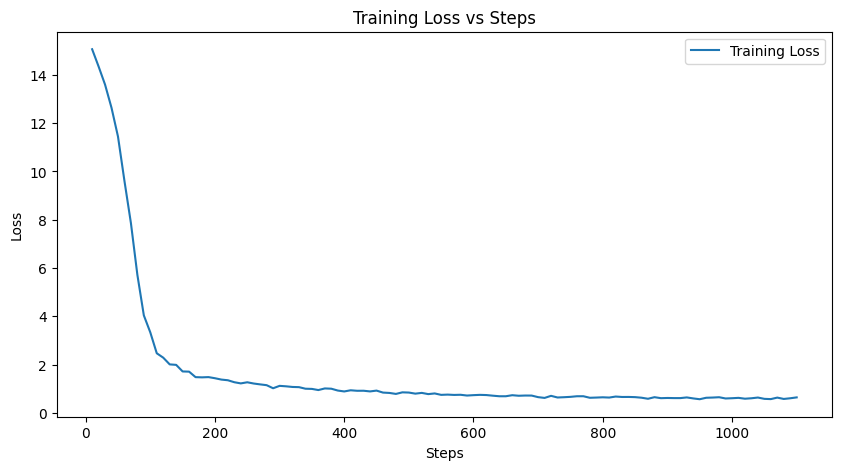

In [ ]:
import torch
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt

# Clear GPU cache
torch.cuda.empty_cache()

# Import the data
data_import = load_dataset("coai/plantuml_generation")

def prepare_input(input_data):
    segments = re.sub(r'|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': segments[1].strip()
    }

prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

data_frame = pd.DataFrame(prepared_data_array)

# Split the data as train and test data
train_df, val_df = train_test_split(data_frame, test_size=0.1, random_state=42)

# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

# Add special tokens to the tokenizer (if any)
special_tokens_dict = {'additional_special_tokens': ['</s>']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

# Resize model's token embeddings to fit the additional special tokens
model.resize_token_embeddings(len(tokenizer))

# Prepare the data for T5
def prepare_data_for_t5(batch):
    inputs = tokenizer(batch['description'], padding='max_length', truncation=True, max_length=512)
    outputs = tokenizer(batch['plantUML_code'], padding='max_length', truncation=True, max_length=512)
    inputs['labels'] = outputs['input_ids']
    return inputs

# Create a PyTorch dataset
class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Convert the dataframes to datasets
train_dataset = T5Dataset(train_df.apply(prepare_data_for_t5, axis=1).values.tolist())
val_dataset = T5Dataset(val_df.apply(prepare_data_for_t5, axis=1).values.tolist())

# Define the training arguments with additional parameters for saving the best model
training_args = TrainingArguments(
    output_dir='./results_t5_base',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,  # Limits the total amount of checkpoints, deletes the older checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss to determine the best model
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Plotting training loss vs iterations
# You can retrieve the training loss from the trainer's state
loss_history = trainer.state.log_history

# Extract the loss values and their corresponding steps
steps = [entry['step'] for entry in loss_history if 'loss' in entry]
losses = [entry['loss'] for entry in loss_history if 'loss' in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.show()
